In [5]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)

## Preparación de datos

In [6]:
# Cargar el dataset desde el archivo CSV
bsd_train_path = '../../data/data_small/bike-sharing-demand/train.csv'
bsd_df = pd.read_csv(bsd_train_path, parse_dates=['datetime'])

bsd_df['datetime'] = pd.to_datetime(bsd_df['datetime'])
bsd_df['year'] = bsd_df['datetime'].dt.year
bsd_df['month'] = bsd_df['datetime'].dt.month
bsd_df['day'] = bsd_df['datetime'].dt.day
bsd_df['hour'] = bsd_df['datetime'].dt.hour
bsd_df['weekday'] = bsd_df['datetime'].dt.weekday
bsd_df['day_type'] = bsd_df['datetime'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [7]:
# Separar características y variable objetivo
X = bsd_df.drop(['count', 'datetime'], axis=1)
y = bsd_df['count']

# Dividir en conjuntos de entrenamiento y prueba
separar_por_dia = True
if separar_por_dia:
    day_ids = ((bsd_df['year']-2011)*356)+((bsd_df['month']-1)*31)+bsd_df['day']

    day_ids_unique = day_ids.unique()

    np.random.shuffle(day_ids_unique)
    day_ids_training = day_ids_unique[:int(len(day_ids_unique)*0.8)]
    day_ids_testing = day_ids_unique[int(len(day_ids_unique)*0.8):]

    is_training = day_ids.isin(day_ids_training)

    X_train = X[is_training]
    X_test = X[~is_training]
    y_train = y[is_training]
    y_test = y[~is_training]

else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Definir variables categóricas y numéricas
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'hour', 'weekday', 'year', 'day_type']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'month']

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Aplicar preprocesamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## Definición y Entrenamiento de Modelos

### Definicion de Modelos clásicos

In [9]:
# Entrenamiento y Evaluación Inicial de Modelos
# -----------------------------------------------
# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

base_lr = LinearRegression().fit(X_train_preprocessed, y_train)
base_lr_pred = base_lr.predict(X_test_preprocessed)
base_lr_pred[base_lr_pred<1] = 1

base_rf = RandomForestRegressor().fit(X_train_preprocessed, y_train)
base_rf_pred = base_rf.predict(X_test_preprocessed)
base_rf_pred[base_rf_pred<1] = 1

### Evaluacion de modelos clasicos sin optimizar

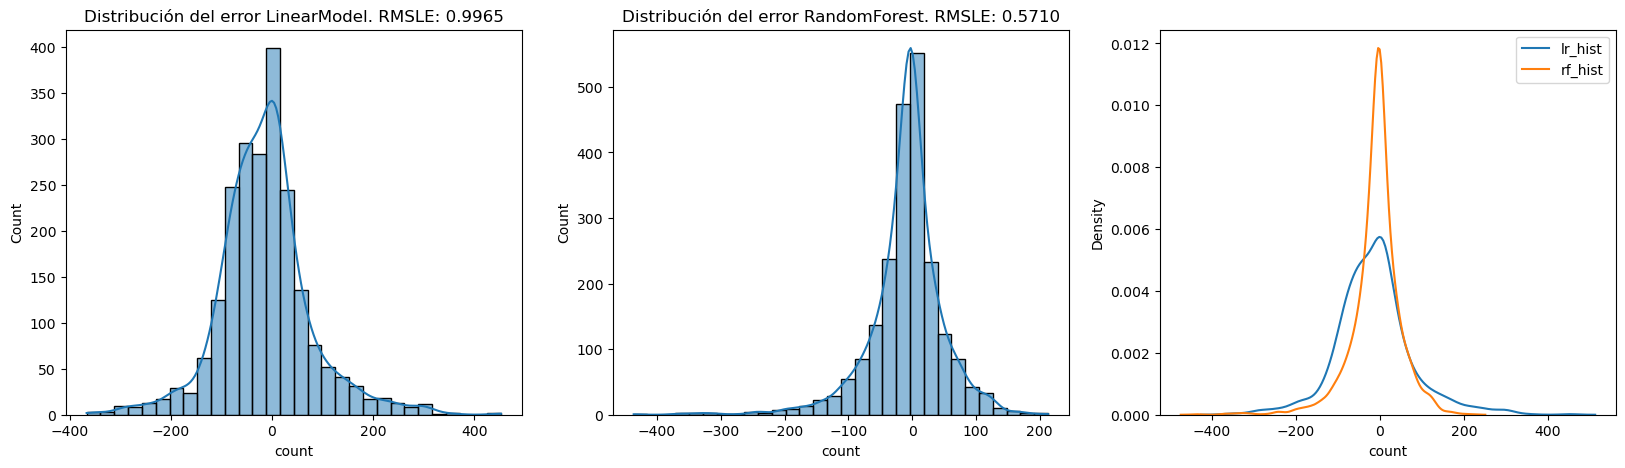

In [10]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
sns.histplot(y_test - base_lr_pred, bins=30, kde=True, ax=axs[0])
rmsle  = root_mean_squared_log_error(y_test, base_lr_pred)
axs[0].set_title(f'Distribución del error LinearModel. RMSLE: {rmsle:.4f}')

sns.histplot(y_test - base_rf_pred, bins=30, kde=True, ax=axs[1])
rmsle  = root_mean_squared_log_error(y_test, base_rf_pred)
axs[1].set_title(f'Distribución del error RandomForest. RMSLE: {rmsle:.4f}')

sns.kdeplot(y_test - base_lr_pred, ax=axs[2], label='lr_hist')
sns.kdeplot(y_test - base_rf_pred, ax=axs[2], label='rf_hist')

plt.legend()
plt.show()

In [11]:
# 6. Optimización de Hiperparámetros para Random Forest
# -----------------------------------------------------
# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, None]
}

# GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=12)
grid_search.fit(X_train_preprocessed, y_train)

# Mejor modelo
best_rf = grid_search.best_estimator_
print("\nMejores hiperparámetros para Random Forest:", grid_search.best_params_)


Mejores hiperparámetros para Random Forest: {'max_depth': None, 'n_estimators': 400}


### Evaluacion de modelos clasicos hyperparametros optimizados

In [12]:
# 7. Evaluación Final en el Conjunto de Prueba
# --------------------------------------------
# Entrenar modelos finales
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train)

rf = best_rf
rf.fit(X_train_preprocessed, y_train)

# Predicciones
y_pred_lr = lr.predict(X_test_preprocessed)
y_pred_rf = rf.predict(X_test_preprocessed)

# Métricas de evaluación
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluar ambos modelos
metrics_lr = evaluate_model(y_test, y_pred_lr)
metrics_rf = evaluate_model(y_test, y_pred_rf)

print("\nEvaluación en el conjunto de prueba:")
print("Regresión Lineal:")
for metric, value in metrics_lr.items():
    print(f"{metric}: {value:.2f}")

print("\nRandom Forest Optimizado:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.2f}")

# 8. Selección del Mejor Modelo
# -----------------------------
# Comparar RMSE (menor es mejor)
if metrics_rf['RMSE'] < metrics_lr['RMSE']:
    print("\nEl mejor modelo es Random Forest con un RMSE de {:.2f}".format(metrics_rf['RMSE']))
else:
    print("\nEl mejor modelo es Regresión Lineal con un RMSE de {:.2f}".format(metrics_lr['RMSE']))


Evaluación en el conjunto de prueba:
Regresión Lineal:
MSE: 9097.31
RMSE: 95.38
MAE: 71.55
R2: 0.70

Random Forest Optimizado:
MSE: 3408.08
RMSE: 58.38
MAE: 37.83
R2: 0.89

El mejor modelo es Random Forest con un RMSE de 58.38


### Deep Learning - Fully Connected Neural Network

#### Implementar la red neuronal

Se implementan capas lineales y funciones de activación ReLU

In [13]:
import torch
import torch.nn as nn

class BikeDemandPredictor(nn.Module):
    def __init__(self, input_size):
        super(BikeDemandPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Entrenar red neuronal

In [14]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_features = X_train_preprocessed.toarray()
train_target = np.expand_dims(y_train, -1)
val_features = X_test_preprocessed.toarray()
val_target = np.expand_dims(y_test, -1)

train_features = torch.tensor(train_features)
train_target = torch.tensor(train_target)
val_features = torch.tensor(val_features)
val_target = torch.tensor(val_target)

# train_features

# Crear conjuntos de datos y cargadores
train_dataset = TensorDataset(train_features, train_target)
val_dataset = TensorDataset(val_features, val_target)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Instanciar la red
input_size = train_features.shape[1]  # Número de características
model = BikeDemandPredictor(input_size)

# Definir la función de pérdida (L1Loss para regresión)
criterion = nn.L1Loss()

# Definir el optimizador (Adam es una buena opción inicial)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Número de épocas
num_epochs = 2000
val_losses = []
min_val_loss_epoch = 0
patience = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()  # Poner el modelo en modo de entrenamiento
    train_loss = 0.0
    for features, targets in train_loader:
        # En el bucle de entrenamiento:
        features = features.to(device).type(torch.float32)
        targets = targets.to(device).type(torch.float32)

        optimizer.zero_grad()  # Reiniciar los gradientes
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, targets)  # Calcular la pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los pesos
        train_loss += loss.item() * features.size(0)  # Acumular la pérdida
    train_loss /= len(train_loader.dataset)  # Promedio de la pérdida de entrenamiento

    # Evaluación en el conjunto de validación
    model.eval()  # Poner el modelo en modo de evaluación
    val_loss = 0.0
    with torch.no_grad():  # Sin calcular gradientes
        for features, targets in val_loader:
            features = features.to(device).type(torch.float32)
            targets = targets.to(device).type(torch.float32)

            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * features.size(0)
        val_loss /= len(val_loader.dataset)  # Promedio de la pérdida de validación

    val_losses.append(val_loss)
    gloabl_val_loss = np.array(val_losses).min()
    if val_losses[-1] <= gloabl_val_loss:
        min_val_loss_epoch = epoch
        torch.save(model.state_dict(), 'bike_demand_best_nn_model_.pth')

    if len(val_losses) - min_val_loss_epoch > patience:
        print('Deteniendo el modelo por patience term')
        break

    # Imprimir las pérdidas
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Global Val Loss: {gloabl_val_loss:.4f}') # 23.5454

Epoch 1/2000, Train Loss: 129.1865, Val Loss: 83.7207, Global Val Loss: 83.7207
Epoch 2/2000, Train Loss: 75.9070, Val Loss: 63.5126, Global Val Loss: 63.5126
Epoch 3/2000, Train Loss: 61.1247, Val Loss: 54.1362, Global Val Loss: 54.1362
Epoch 4/2000, Train Loss: 52.6067, Val Loss: 46.2103, Global Val Loss: 46.2103
Epoch 5/2000, Train Loss: 45.2591, Val Loss: 42.3221, Global Val Loss: 42.3221
Epoch 6/2000, Train Loss: 38.5598, Val Loss: 37.0035, Global Val Loss: 37.0035
Epoch 7/2000, Train Loss: 34.1938, Val Loss: 35.0290, Global Val Loss: 35.0290
Epoch 8/2000, Train Loss: 31.8058, Val Loss: 34.8546, Global Val Loss: 34.8546
Epoch 9/2000, Train Loss: 30.5166, Val Loss: 34.1698, Global Val Loss: 34.1698
Epoch 10/2000, Train Loss: 29.6408, Val Loss: 32.9517, Global Val Loss: 32.9517
Epoch 11/2000, Train Loss: 28.7756, Val Loss: 32.4226, Global Val Loss: 32.4226
Epoch 12/2000, Train Loss: 28.0658, Val Loss: 31.4244, Global Val Loss: 31.4244
Epoch 13/2000, Train Loss: 27.2867, Val Loss: 30

#### Funcion para predecir con red neuronal

In [17]:
def dl_model_predict(model, X_data, device):
    with torch.no_grad():  # Sin calcular gradientes
        features = torch.tensor(X_data, dtype=torch.float32, device=device)

        outputs = model(features)

    return outputs.cpu().numpy()

model.load_state_dict(torch.load(('bike_demand_best_nn_model_.pth'), map_location=torch.device('cpu')))

<All keys matched successfully>

### Grafica de Comparación y Evaluación de modelos

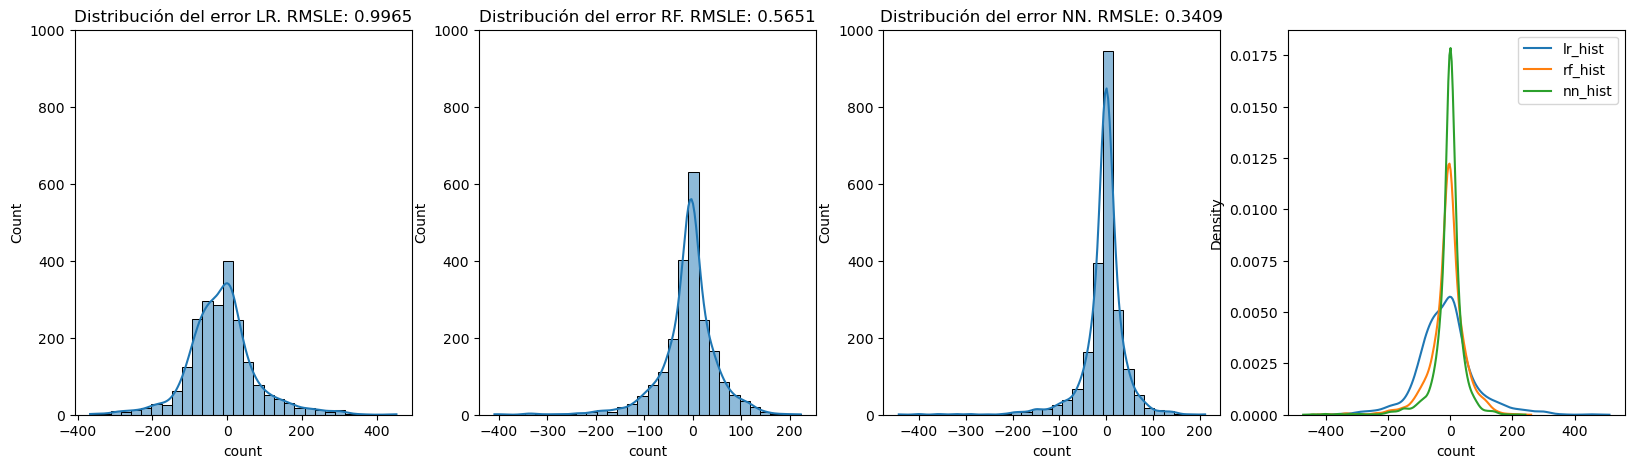

In [18]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
sns.histplot(y_test - base_lr_pred, bins=30, kde=True, ax=axs[0])
rmsle  = root_mean_squared_log_error(y_test, base_lr_pred)
axs[0].set_title(f'Distribución del error LR. RMSLE: {rmsle:.4f}')

sns.histplot(y_test - y_pred_rf, bins=30, kde=True, ax=axs[1])
rmsle  = root_mean_squared_log_error(y_test, y_pred_rf)
axs[1].set_title(f'Distribución del error RF. RMSLE: {rmsle:.4f}')

nn_preds = dl_model_predict(model, X_test_preprocessed.toarray(), device)[:,0]
nn_preds[nn_preds<1] = 1
sns.histplot(y_test - nn_preds, bins=30, kde=True, ax=axs[2])
rmsle  = root_mean_squared_log_error(y_test, nn_preds)
axs[2].set_title(f'Distribución del error NN. RMSLE: {rmsle:.4f}')

for ax in axs[:-1]:
    ax.set_ylim(0, 1000)

sns.kdeplot((y_test - base_lr_pred), ax=axs[3], label='lr_hist')
sns.kdeplot((y_test - y_pred_rf), ax=axs[3], label='rf_hist')
sns.kdeplot((y_test - nn_preds), ax=axs[3], label='nn_hist')

plt.legend()
plt.show()

In [19]:
lr_pred = lr.predict(X_test_preprocessed)
lr_pred[lr_pred<1] = 1

rf_pred = rf.predict(X_test_preprocessed)
rf_pred[rf_pred<1] = 1

nn_pred = dl_model_predict(model, X_test_preprocessed.toarray(), device)[:,0]
nn_pred[nn_pred<1] = 1

models_names = {
    'Model': ['LR', 'RF', 'NN'],
}
metrics = {
    'MSE': [
        mean_squared_error(y_test, lr_pred),
        mean_squared_error(y_test, rf_pred),
        mean_squared_error(y_test, nn_pred),
    ],
    'MAE': [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, nn_pred),
    ],
    'RMSLE': [
        root_mean_squared_log_error(y_test, lr_pred),
        root_mean_squared_log_error(y_test, rf_pred),
        root_mean_squared_log_error(y_test, nn_pred),
    ]
}

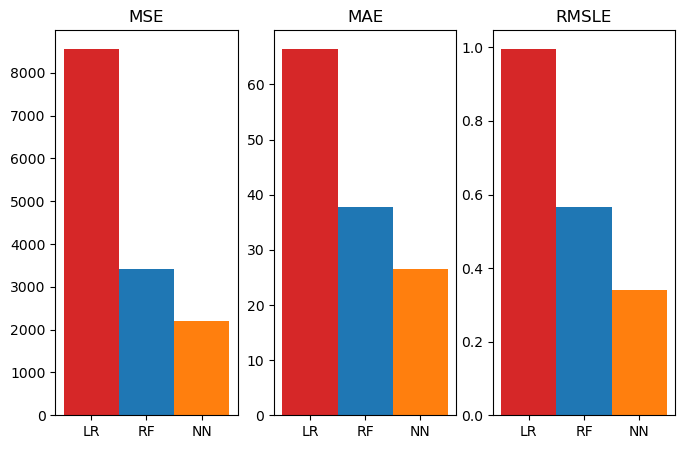

In [20]:
fig, axs = plt.subplots(1,len(metrics.keys()),figsize=(8,5))

bar_colors = ['tab:red', 'tab:blue', 'tab:orange']
for indx, (metric_name, metric) in enumerate(metrics.items()):
    axs[indx].bar(models_names['Model'], metric, color=bar_colors, width=1.0)
    axs[indx].set_title(metric_name)

plt.show()

## Experimento de predicción de día entero

LR MAE: 63.2035
RF MAE: 23.3191
NN MAE: 16.5056


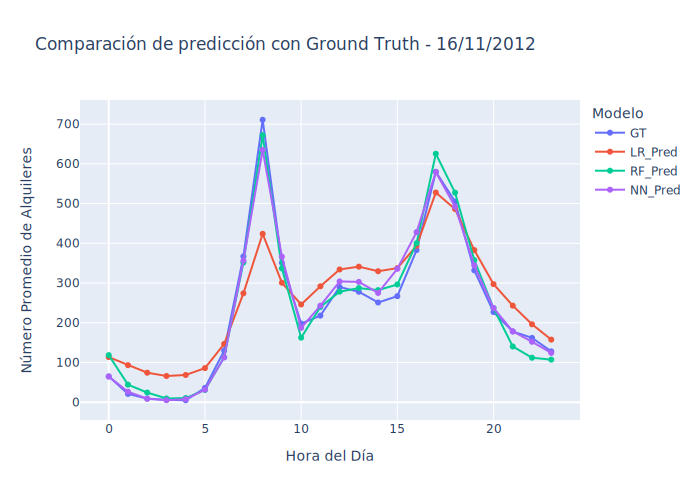

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

# Seleccionar data de un dia random
X_experiment = X_test[X_test['day_type']=='Weekday']
y_experiment = y_test[X_test['day_type']=='Weekday']
random_year, random_month, random_day = X_experiment.sample(1)[['year', 'month', 'day']].iloc[0]
filtro_fecha = (X_experiment['year'] == random_year) & (X_experiment['month'] == random_month) & (X_experiment['day'] == random_day)

X_dia = X_experiment.loc[filtro_fecha]
X_dia = preprocessor.transform(X_dia)
y_dia = y_experiment[filtro_fecha]

# Calcular predicciones
pred_day_lr = lr.predict(X_dia)
pred_day_rf = rf.predict(X_dia)
pred_day_nn = dl_model_predict(model, X_dia.toarray(), device)[:,0]

# Calcular MAE
lr_mae = np.abs(y_dia - pred_day_lr).mean()
rf_mae = np.abs(y_dia - pred_day_rf).mean()
nn_mae = np.abs(y_dia - pred_day_nn).mean()

title_errors = f'LR MAE: {lr_mae:.4f}\nRF MAE: {rf_mae:.4f}\nNN MAE: {nn_mae:.4f}'
print(title_errors)

# Preparar DF para el plot
output_data = {
    'hour': list(range(len(y_dia))),
    'GT': y_dia,  # Ground Truth
    'LR_Pred': pred_day_lr,  # Linear Regression Prediction
    'RF_Pred': pred_day_rf,  # Random Forest Prediction
    'NN_Pred': pred_day_nn   # Random Forest Prediction
}

output_data_df = pd.DataFrame(output_data)

df_long = pd.melt(output_data_df, 
                  id_vars=['hour'], 
                  value_vars=['GT', 'LR_Pred', 'RF_Pred', 'NN_Pred'],
                  var_name='model_type', 
                  value_name='count')

# Plot
le_title = (f'Comparacion de prediccion con Ground Truth - {random_day}/{random_month}/{random_year}')
fig = px.line(df_long, x='hour', y='count', color='model_type',
              title=f'{le_title}',
              labels={'hour': 'Hora del Dia', 'count': 'Numero Promedio de Alquileres', 'model_type': 'Modelo'},
              markers=True)
fig.show()